# Unsupervised learning

When we do error-modulated learning with the `nengo.PES` rule,
we have a pretty clear idea of what we want to happen.
Years of neuroscientific experiments have yielded
learning rules explaining how synaptic strengths
change given certain stimulation protocols.
But what do these learning rules actually do
to the information transmitted across an
ensemble-to-ensemble connection?

We can investigate this in Nengo.
Currently, we've implemented the `nengo.BCM`
and `nengo.Oja` rules.

# NC Project

Members:
- Ludovic Jozeau
- Alexandre Jousset

# The idea:

We take two Ensemble, the first has 28x28(=784) neurons, one neurons by pixel of the input image.
The second Ensemble has 20 neurons but it could be more or less, the idea is to have more output neurons than the number of classes.

We connect those two Ensemble together and add a learning rule to it (BCM, Oja, ...)

to train the model, we present the images of the train dataset one by one over time, the presentation time of each images is constant(e.g: 0.35s)

then we can freeze the weights of the model and represent all the same images to see how the model classify them. To do this we see how much time each neurons of the output react to each images. those firing the most for a certain class are the ones that recognize this class.

we can then assign output neurons to a class, and take the mean to have a percentage of certainty.

lastly, we can test the model with the test dataset and see how the models classify each images

We found a neuron implementation of a [AdaptiveLIFLateralInhibition](https://github.com/thomastiotto/Memristor-Nengo), that can "differentiate" each images over time by setting `reset_every=presentation_time`

We listed some ideas of improvements at the end

In [196]:
import tensorflow as tf
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

from typing import Literal

import nengo
import nengo.neurons
import nengo.solvers
import nengo_dl
import nengo.spa as spa
from tqdm import tqdm

In [197]:
def load_dataset() -> tuple[tuple[np.ndarray[tuple[Literal[60000], Literal[28], Literal[28]], np.dtype[np.uint8]], np.ndarray[tuple[Literal[60000]], np.dtype[np.uint8]]], tuple[np.ndarray[tuple[Literal[60000], Literal[28], Literal[28]], np.dtype[np.uint8]], np.ndarray[tuple[Literal[60000]], np.dtype[np.uint8]]]]:
    return tf.keras.datasets.mnist.load_data()

(train_images, train_labels), (
    test_images,
    test_labels,
) = load_dataset()

print(train_images.shape, train_images.dtype)
print(train_labels.shape, train_labels.dtype)
print(test_images.shape, test_images.dtype)
print(test_labels.shape, test_labels.dtype)

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


In [198]:
# # add single timestep to training data
# train_images = train_images[:, None, :]
# train_labels = train_labels[:, None, None]

# # when testing our network with spiking neurons we will need to run it
# # over time, so we repeat the input/target data for a number of
# # timesteps.
# n_steps = 5
# test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
# test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

## Step 1: Create a simple communication channel

The only difference between this network and most
models you've seen so far is that we're going to
set the decoder solver in the communication channel
to generate a full connection weight matrix
which we can then learn using typical delta learning rules.

In [199]:
dt = 0.001
sample_every = 100 * dt
presentation_time = 0.35
out_neurons = 50

nb_img = 600
# compute exact time for a run to have presentation_time times an int
# but we need roughly 10sec of sim time
# we need to split the run in multiple runs of 10s as the sim.run allocate for the whole input
nb_sec_by_run = np.round(presentation_time * np.ceil(10 / presentation_time), 2)
print(f"nb_sec_by_run: {nb_sec_by_run}")
nb_train_run = int(np.ceil((nb_img * presentation_time) / nb_sec_by_run))
sim_train_time = np.round(nb_train_run * nb_sec_by_run, 2)
real_nb_img = int(sim_train_time / presentation_time)

sample_every_weights =  sim_train_time

# normalize images and shift half to negative values -> based on behavior of learning rules
reduced_train_images = (train_images[0:real_nb_img] / 255 - 0.5) * 2
reduced_train_labels = train_labels[0:real_nb_img]

train_test_prop = len(train_images) / len(test_images)
print(f"Train/test: {train_test_prop}")
nb_test_img = min(int(real_nb_img / train_test_prop) * 2, len(test_images) - 30)
nb_test_run = int(np.ceil((nb_test_img * presentation_time) / nb_sec_by_run))
sim_test_time = np.round(nb_test_run * nb_sec_by_run, 2)
real_nb_test_img = int(sim_test_time / presentation_time)

reduced_test_images = (test_images[0:real_nb_test_img] / 255 - 0.5) * 2
reduced_test_labels = test_labels[0:real_nb_test_img]
print(f"nb train runs: {nb_train_run}")
print(f"nb train img: {real_nb_img}")
print(f"nb test runs: {nb_test_run}")
print(f"nb test images: {real_nb_test_img}")
print(f"Train Simulation time: {sim_train_time}s")
print(f"ETA of IRL simulation (post.neuron_type=LIF): {real_nb_img * 0.05438}s")

assert(np.round(real_nb_img * presentation_time / nb_sec_by_run, 10).is_integer())
assert(np.round(real_nb_test_img * presentation_time / nb_sec_by_run, 10).is_integer())


nb_sec_by_run: 10.15
Train/test: 6.0
nb train runs: 21
nb train img: 609
nb test runs: 7
nb test images: 203
Train Simulation time: 213.15s
ETA of IRL simulation (post.neuron_type=LIF): 33.117419999999996s


In [200]:
print(f"{np.max(reduced_test_images)}, {np.min(reduced_test_images)}")
print(f"total sim time for the whole dataset: {presentation_time * train_images.shape[ 0 ]}s")

1.0, -1.0
total sim time for the whole dataset: 21000.0s


In [201]:
# neuron from https://github.com/thomastiotto/Memristor-Nengo

import numpy as np
from decimal import Decimal
import math

from nengo.neurons import LIF
from nengo.params import NumberParam
from nengo.dists import Uniform, Choice
from nengo.utils.numpy import clip


class AdaptiveLIFLateralInhibition( LIF ):
    state = {
            "voltage"        : Uniform( low=0, high=1 ),
            "refractory_time": Choice( [ 0 ] ),
            "adaptation"     : Choice( [ 0 ] ),
            "inhibition"     : Choice( [ 0 ] )
            }
    spiking = True
    
    tau_n = NumberParam( "tau_n", low=0, low_open=True )
    inc_n = NumberParam( "inc_n", low=0 )
    tau_inhibition = NumberParam( "tau_inhibition", low=0 )
    
    def __init__(
            self,
            tau_n=1,
            inc_n=0.01,
            tau_rc=0.02,
            tau_ref=0.002,
            min_voltage=0,
            amplitude=1,
            initial_state=None,
            tau_inhibition=10,
            reset_every=0.35
            ):
        super().__init__(
                tau_rc=tau_rc,
                tau_ref=tau_ref,
                min_voltage=min_voltage,
                amplitude=amplitude,
                initial_state=initial_state,
                )
        self.tau_n = tau_n
        self.inc_n = inc_n
        self.tau_inhibition = tau_inhibition
        self.reset_every = reset_every
        self.sim_time = 0.0
    
    def step( self, dt, J, output, voltage, refractory_time, adaptation, inhibition ):
        """Implement the AdaptiveLIF nonlinearity."""
        
        # look these up once to avoid repeated parameter accesses
        tau_rc = self.tau_rc
        min_voltage = self.min_voltage
        tau_inhibition = self.tau_inhibition
        tau_ref = self.tau_ref
        tau_n = self.tau_n
        inc_n = self.inc_n
        reset_every = self.reset_every
        
        # reduce input by the adaptation
        J = J - adaptation
        
        # reset neurons (except for adaptation) after each sample is presented
        self.sim_time += dt
        if math.isclose( math.fmod( self.sim_time, reset_every ), 0, abs_tol=1e-3 ):
            J[ ... ] = 0
            voltage[ ... ] = 0
            refractory_time[ ... ] = 0
            inhibition[ ... ] = 0
        
        # reduce all refractory times by dt
        refractory_time -= dt
        
        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = clip( (dt - refractory_time), 0, dt )
        
        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        voltage -= (J - voltage) * np.expm1( -delta_t / tau_rc )
        
        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > 1
        output[ : ] = spiked_mask * (self.amplitude / dt)
        
        # if neuron that spiked had highest input but was still inhibited from a previous timestep
        voltage[ inhibition != 0 ] = 0
        output[ inhibition != 0 ] = 0
        spiked_mask[ inhibition != 0 ] = False
        
        if np.count_nonzero( output ) > 0:
            # inhibit all other neurons than one with highest input
            voltage[ J != np.max( J ) ] = 0
            output[ J != np.max( J ) ] = 0
            spiked_mask[ J != np.max( J ) ] = False
            inhibition[ (J != np.max( J )) & (inhibition == 0) ] = tau_inhibition
        
        # set v(0) = 1 and solve for t to compute the spike time
        t_spike = dt + tau_rc * np.log1p(
                -(voltage[ spiked_mask ] - 1) / (J[ spiked_mask ] - 1)
                )
        
        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[ voltage < min_voltage ] = min_voltage
        voltage[ spiked_mask ] = 0
        refractory_time[ spiked_mask ] = tau_ref + t_spike
        
        adaptation += (dt / tau_n) * (inc_n * output - adaptation)
        
        inhibition[ inhibition != 0 ] -= 1


import tensorflow as tf
from nengo_dl.neuron_builders import SoftLIFRateBuilder, LIFRateBuilder, LIFBuilder


class AdaptiveLIFLateralInhibitionBuilder( SoftLIFRateBuilder ):
    """Build a group of `~nengo.LIF` neuron operators."""
    
    spiking = True
    
    def build_pre( self, signals, config ):
        # note: we skip the SoftLIFRateBuilder init
        # pylint: disable=bad-super-call
        super( SoftLIFRateBuilder, self ).build_pre( signals, config )
        
        self.min_voltage = signals.op_constant(
                [ op.neurons for op in self.ops ],
                [ op.J.shape[ 0 ] for op in self.ops ],
                "min_voltage",
                signals.dtype,
                )
        self.tau_n = signals.op_constant(
                [ op.neurons for op in self.ops ],
                [ op.J.shape[ 0 ] for op in self.ops ],
                "tau_n",
                signals.dtype,
                )
        self.inc_n = signals.op_constant(
                [ op.neurons for op in self.ops ],
                [ op.J.shape[ 0 ] for op in self.ops ],
                "inc_n",
                signals.dtype,
                )
        self.tau_inhibition = signals.op_constant(
                [ op.neurons for op in self.ops ],
                [ op.J.shape[ 0 ] for op in self.ops ],
                "tau_inhibition",
                signals.dtype,
                )
    
    def step( self, J, dt, voltage, refractory_time, adaptation, inhibition ):
        """Implement the AdaptiveLIF nonlinearity."""
        
        def inhibit( voltage, output, inhibition, spiked_mask ):
            # inhibit all other neurons than one with highest input
            J_mask = tf.equal( J, tf.reduce_max( J ) )
            
            voltage = tf.multiply( voltage, tf.cast( J_mask, voltage.dtype ) )
            output = tf.multiply( output, tf.cast( J_mask, output.dtype ) )
            spiked_mask = tf.logical_and( spiked_mask, tf.cast( J_mask, spiked_mask.dtype ) )
            inhibition = tf.where( tf.logical_and( tf.logical_not( J_mask ), tf.equal( inhibition, 0 ) ),
                                   self.tau_inhibition,
                                   inhibition
                                   )
            
            return voltage, output, inhibition, spiked_mask
        
        J = J - adaptation
        
        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = tf.clip_by_value( dt - refractory_time, self.zero, dt )
        
        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        dV = (voltage - J) * tf.math.expm1(
                -delta_t / self.tau_rc  # pylint: disable=invalid-unary-operand-type
                )
        voltage += dV
        
        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > self.one
        output = tf.cast( spiked_mask, J.dtype ) * self.alpha
        
        inhibition_mask = tf.equal( inhibition, 0 )
        # if neuron that spiked had highest input but was still inhibited from a previous timestep
        voltage = tf.multiply( voltage, tf.cast( inhibition_mask, voltage.dtype ) )
        output = tf.multiply( output, tf.cast( inhibition_mask, output.dtype ) )
        spiked_mask = tf.logical_and( spiked_mask, tf.cast( inhibition_mask, spiked_mask.dtype ) )
        
        # inhibit all other neurons than one with highest input
        voltage, output, inhibition, spiked_mask = tf.cond( tf.math.count_nonzero( output ) > 0,
                                                            lambda: inhibit( voltage, output, inhibition, spiked_mask ),
                                                            lambda: (tf.identity( voltage ),
                                                                     tf.identity( output ),
                                                                     tf.identity( inhibition ),
                                                                     tf.identity( spiked_mask )
                                                                     )
                                                            )
        
        # set v(0) = 1 and solve for t to compute the spike time
        t_spike = dt + self.tau_rc * tf.math.log1p( -(voltage - 1) / (J - 1) )
        
        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage = tf.where( spiked_mask, self.zeros, tf.maximum( voltage, self.min_voltage ) )
        refractory_time = tf.where( spiked_mask, self.tau_ref + t_spike, refractory_time - dt )
        
        adaptation += (dt / self.tau_n) * (self.inc_n * output - adaptation)
        
        inhibition_mask = tf.not_equal( inhibition, 0 )
        inhibition = tf.tensor_scatter_nd_sub( inhibition,
                                               tf.where( inhibition_mask ),
                                               tf.ones( tf.math.count_nonzero( inhibition_mask ) )
                                               )
        
        return output, voltage, refractory_time, adaptation, inhibition
    
    def training_step( self, J, dt, **state ):
        return (
                LIFRateBuilder.step( self, J, dt )
                if self.config.lif_smoothing is None
                else SoftLIFRateBuilder.step( self, J, dt )
        )


# register with the NengoDL neuron builder
from nengo_dl.neuron_builders import SimNeuronsBuilder

SimNeuronsBuilder.TF_NEURON_IMPL[ AdaptiveLIFLateralInhibition ] = AdaptiveLIFLateralInhibitionBuilder


In [202]:
def present_data_fn_from(data: np.ndarray):
  def inp_fn(t: float):
    return data[int(t / presentation_time) % len(data)]
  return inp_fn


In [203]:
model = nengo.Network()
with model:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None
    # the input node that will be used to feed in input images
    # inp = nengo.Node( nengo.processes.PresentInput( reduced_train_images, presentation_time ) )
    inp = nengo.Node(present_data_fn_from(reduced_train_images))

    # pre = nengo.Ensemble(784, dimensions=1)
    pre = nengo.Ensemble(n_neurons=784, dimensions=1,
                         neuron_type=nengo.neurons.PoissonSpiking(nengo.LIFRate(
                             amplitude=0.01
                         )),
                        #  neuron_type=LIF(amplitude=0.01)
                         # gain=nengo.dists.Choice( [ 2 ] ),
                         # bias=nengo.dists.Choice( [ 1 ] ),
                        #  encoders=nengo.dists.Choice([[1]]),
                        #  intercepts=nengo.dists.Choice([0]),
                        #  max_rates=nengo.dists.Choice([22, 22]),
                         )

    # post = nengo.Ensemble(out_neurons, dimensions=1)
    post = nengo.Ensemble(n_neurons=out_neurons, dimensions=1,
                          neuron_type=AdaptiveLIFLateralInhibition(inc_n=0.01,
                                                                   tau_n=1,
                                                                   tau_inhibition=10,
                                                                   reset_every=presentation_time,
                                                                   amplitude=1
                                                                   ),
                        #   neuron_type=nengo.AdaptiveLIF(inc_n=0.01, tau_n=1),
                          # gain=nengo.dists.Choice( [ 2 ] ),
                          # bias=nengo.dists.Choice( [ 1 ] ),
                          # encoders=nengo.dists.Choice([[1]]),
                        #   intercepts=nengo.dists.Choice([0]),
                        #   max_rates=nengo.dists.Choice([22, 22]),
                          )

    nengo.Connection(inp, pre.neurons)
    # conn = nengo.Connection(pre, post, solver=nengo.solvers.LstsqL2(weights=True))
    conn = nengo.Connection(pre.neurons, post.neurons,
                            # transform=np.random.random( (post.n_neurons, pre.n_neurons) )
                            transform=np.random.normal(
                                loc=0, scale=0.25, size=(post.n_neurons, pre.n_neurons)),
                            # transform=nengo.Convolution(n_filters=1, input_shape=(28,28,1), kernel_size=(5,5), strides=(5,5)),
                            # solver=nengo.solvers.LstsqL2(weights=True)
                            )
    # conn.learning_rule_type = nengo.BCM(learning_rate=1e-6)
    conn.learning_rule_type = nengo.BCM(learning_rate=5e-4)
    # conn.learning_rule_type = nengo.Oja(learning_rate=1e-4)
    # conn.learning_rule_type = [
    #     nengo.BCM(learning_rate=5e-4),
    #     nengo.Oja(learning_rate=2e-4),
    # ]

    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

    pre_value_probe = nengo.Probe( pre )
    pre_probe = nengo.Probe( pre.neurons, sample_every=sample_every )
    post_probe = nengo.Probe( post.neurons, sample_every=dt )
    weight_probe = nengo.Probe( conn, "weights", sample_every=sample_every_weights )
    adaptation_probe = nengo.Probe(
        post.neurons, "adaptation", sample_every=sim_train_time)


In [204]:
train_labels_u, train_labels_nb = np.unique(reduced_train_labels, return_counts=True)
test_labels_u, test_labels_nb = np.unique(reduced_test_labels, return_counts=True )

[0 1 2 3 4 5 6 7 8 9]
[59 80 64 59 61 51 55 63 50 67]
[0 1 2 3 4 5 6 7 8 9]
[17 29 16 17 28 20 21 24 10 21]
203
203
[0.08374384 0.14285714 0.07881773 0.08374384 0.13793103 0.09852217
 0.10344828 0.1182266  0.04926108 0.10344828]


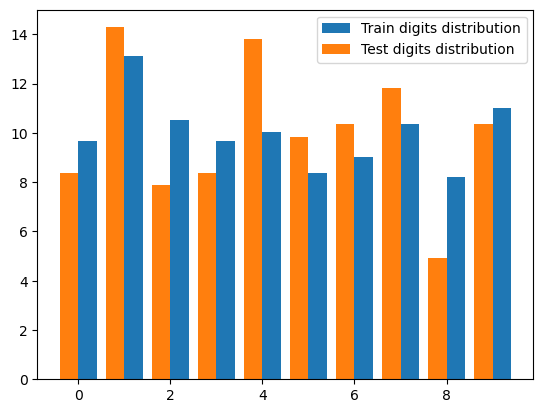

In [205]:
print(train_labels_u)
print(train_labels_nb)
print(test_labels_u)
print(test_labels_nb)
print(sum(test_labels_nb))
print(reduced_test_labels.size)
print(test_labels_nb / reduced_test_labels.size)

plt.figure()
plt.bar(train_labels_u + 0.2, [(c / reduced_train_labels.size * 100)
                         for c in train_labels_nb], 0.4, label="Train digits distribution")
plt.bar(test_labels_u - 0.2, [(c / reduced_test_labels.size * 100)
                        for c in test_labels_nb], 0.4, label="Test digits distribution")
plt.legend()


In [206]:
# Verify that it does a communication channel
with nengo_dl.Simulator(model, device="/cpu:0", progress_bar=False, unroll_simulation=10) as sim_train:
    # print("sim steps:", sim.n_steps)
    for i in tqdm(range(nb_train_run)):
        sim_train.run(nb_sec_by_run, progress_bar=False)
        # print("sim steps:", sim.n_steps)

100%|██████████| 21/21 [00:48<00:00,  2.32s/it]


In [207]:
# taken from https://github.com/thomastiotto/Memristor-Nengo/blob/main/extras.py
def heatmap(probe, t=-1, title="Weights after learning"):
    if probe.shape[1] > 100:
        print("Too many neurons to generate heatmap")
        return

    cols = 10 if probe.shape[1] >= 10 else probe.shape[1]
    rows = (probe.shape[1] / cols) + \
        1 if probe.shape[1] % cols != 0 else probe.shape[1] / cols

    plt.set_cmap('jet')
    fig, axes = plt.subplots(int(rows), int(
        cols), figsize=(12.8, 1.76 * rows), dpi=100)
    for i, ax in enumerate(axes.flatten() if isinstance(axes, np.ndarray) else [axes]):
        assert(isinstance(ax, plt.Axes))
        try:
            ax.matshow(probe[t, i, ...].reshape((28, 28)))
            ax.set_title(f"N. {i}")
            ax.set_yticks([])
            ax.set_xticks([])
        except:
            ax.set_visible(False)
    fig.suptitle(title)
    fig.tight_layout()

    return fig


<Figure size 640x480 with 0 Axes>

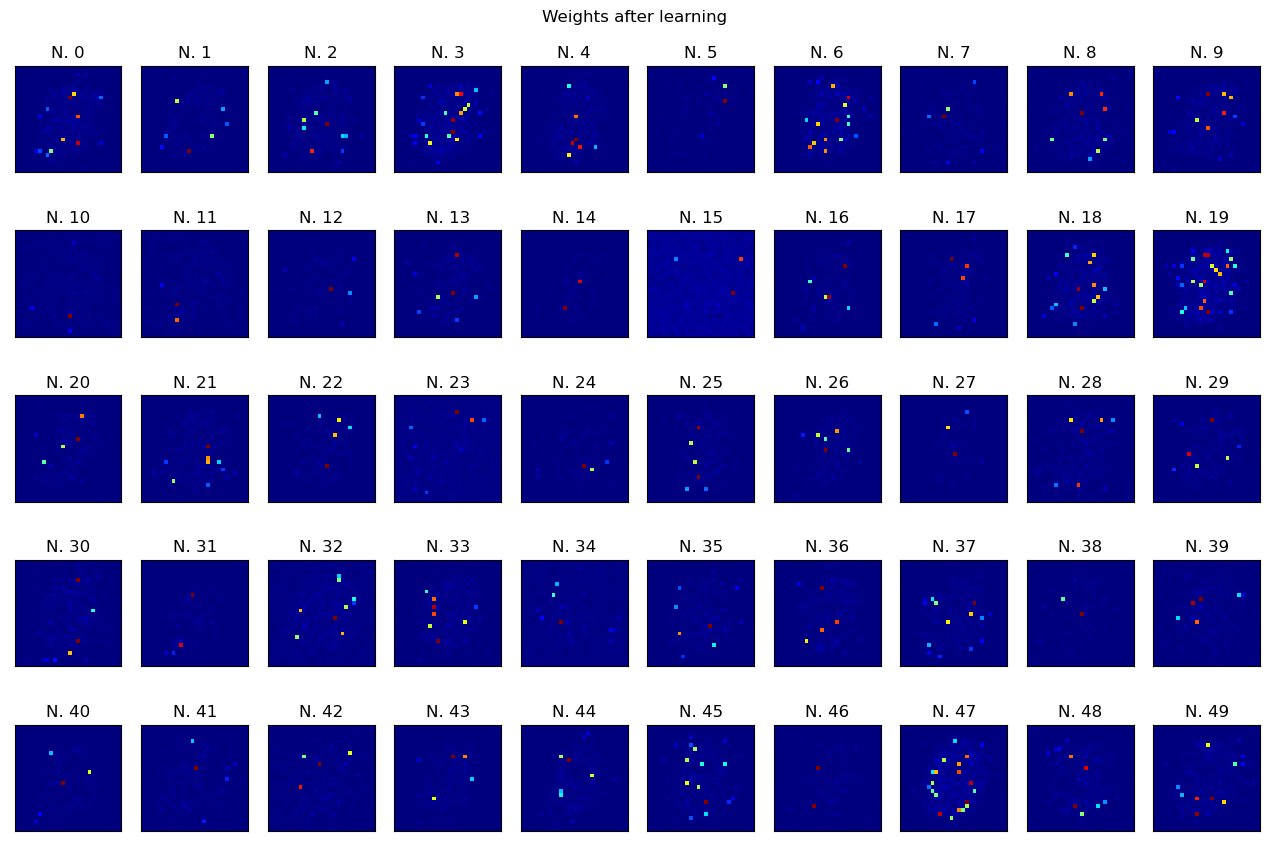

In [208]:
fig = heatmap(sim_train.data[weight_probe], t=-1)


In [209]:
# Eval run
conn.learning_rule_type = nengo.BCM(learning_rate=5e-8)
# freeze weights
conn.transform = sim_train.data[weight_probe][-1].squeeze()
# load last neuron thresholds from training and freeze them
post.neuron_type = AdaptiveLIFLateralInhibition(
    tau_n=float("inf"),
    inc_n=0,
    initial_state={
        "adaptation": sim_train.data[adaptation_probe].squeeze()}
)
# set post probe to record every spike for statistics
post_probe.sample_every = dt
with nengo_dl.Simulator(model, device="/cpu:0", progress_bar=False, unroll_simulation=10) as sim_class:
    # print("sim steps:", sim.n_steps)
    for i in tqdm(range(nb_train_run)):
        sim_class.run(nb_sec_by_run, progress_bar=False)
        # print("sim steps:", sim.n_steps)

100%|██████████| 21/21 [00:49<00:00,  2.37s/it]


<Figure size 640x480 with 0 Axes>

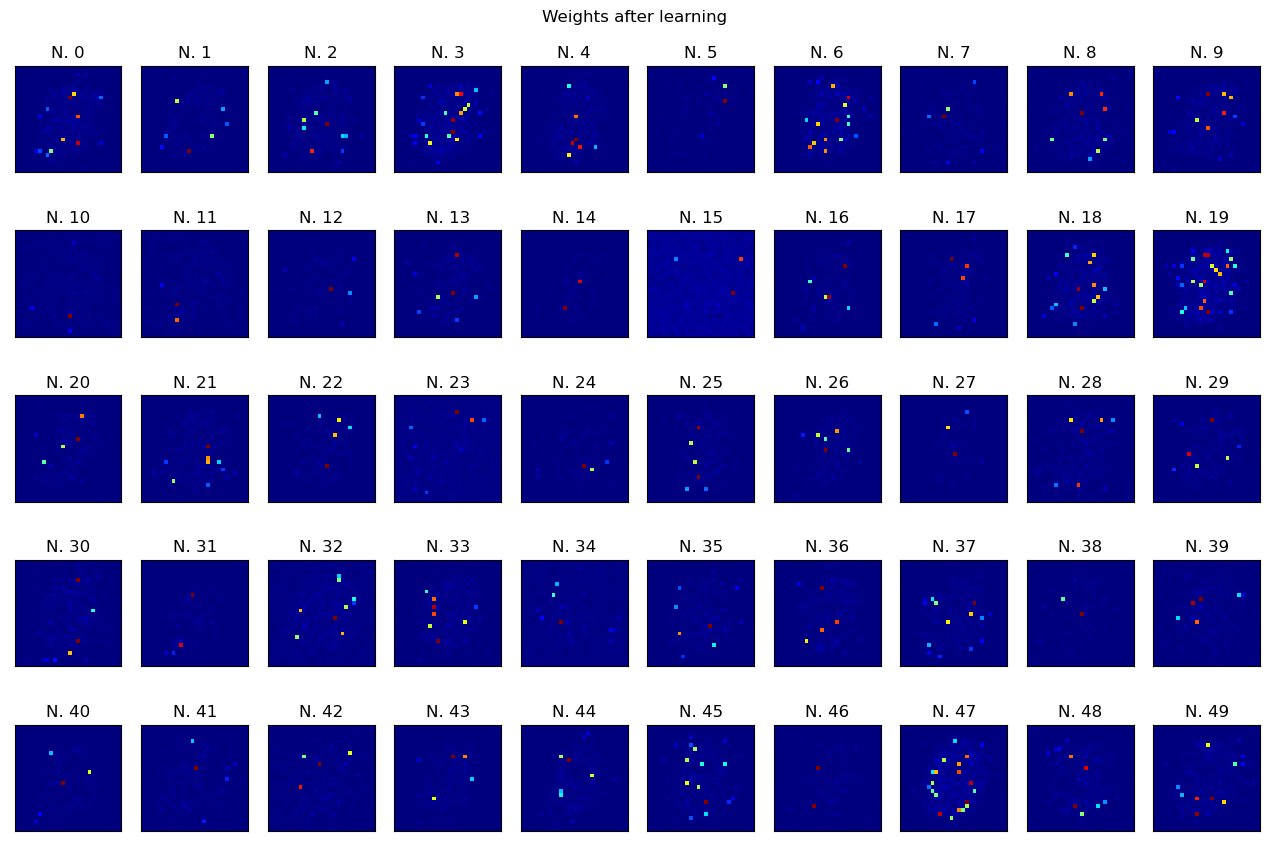

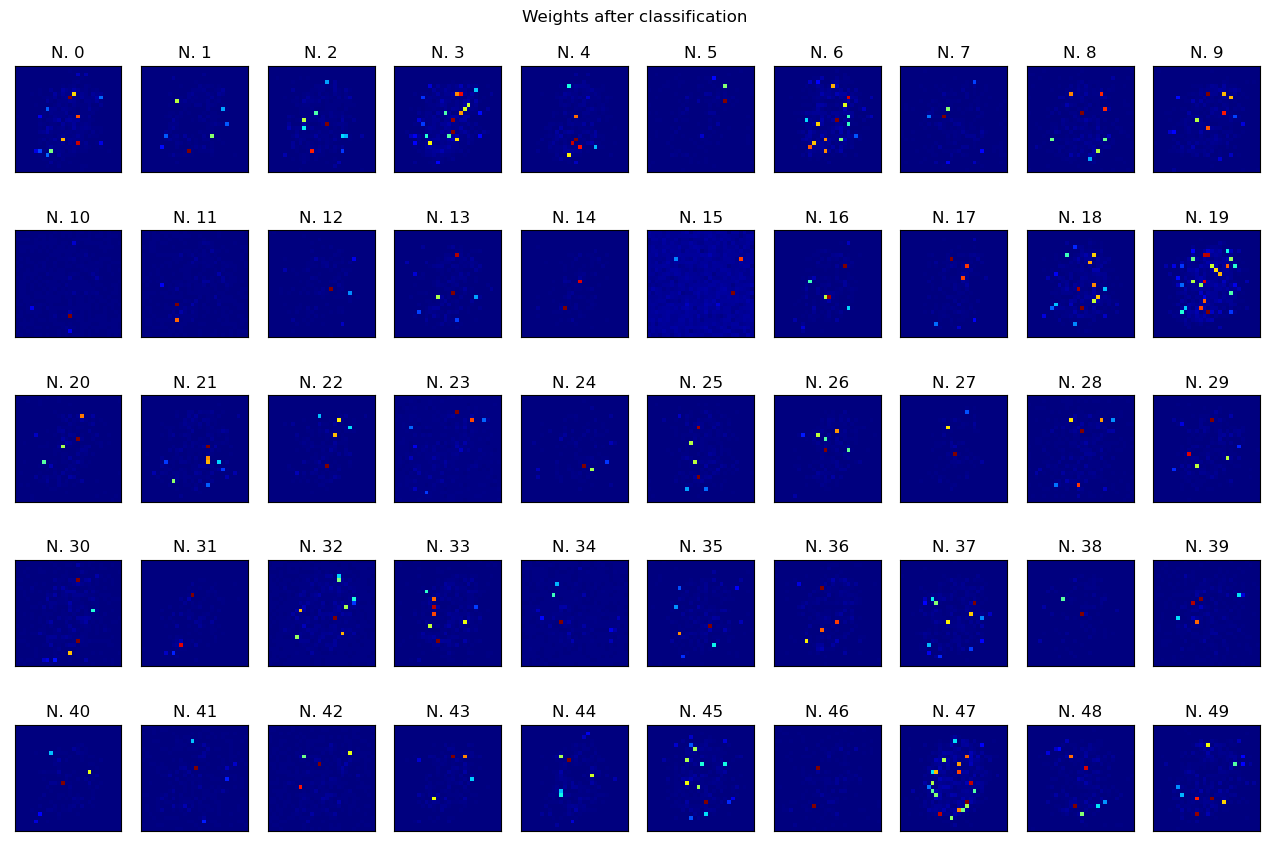

In [210]:
fig = heatmap(sim_train.data[weight_probe], t=-1)
fig = heatmap(sim_class.data[weight_probe], t=-1, title="Weights after classification")


	Total: 9808
	Normalised standard dev.: 0.7849346024616677


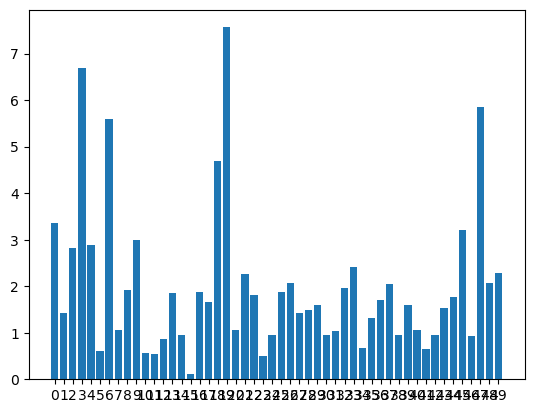

In [211]:
# print number of recorded spikes
num_spikes_class = np.sum(sim_class.data[post_probe] > 0, axis=0)

# for line in graph.graph(f"Spikes distribution (timestep={dt}):",
#                         [(str(i), x / np.sum(num_spikes_class) * 100) for i, x in
#                             enumerate(num_spikes_class)]):
#     print(line)
recorded_spikes = {str(i): x / np.sum(num_spikes_class) * 100
 for i, x in enumerate(num_spikes_class)}
plt.bar(recorded_spikes.keys(), recorded_spikes.values())
print("\tTotal:", np.sum(num_spikes_class))
print(
    f"\tNormalised standard dev.: {np.std( num_spikes_class ) / np.mean( num_spikes_class )}")

post_spikes_class = sim_class.data[post_probe].reshape(
    real_nb_img, -1, out_neurons)

# count neuron activations in response to each example
neuron_activations_class = np.count_nonzero(post_spikes_class, axis=1)

# count how many times each neuron spiked for each label across samples
neuron_label_count = {neur: {int(lab): 0 for lab in train_labels_u}
                      for neur in range(out_neurons)}
for t, lab in enumerate(reduced_train_labels.ravel()):
    for neur in range(out_neurons):
        neuron_label_count[neur][lab] += int(
            neuron_activations_class[t, neur])


In [212]:
for i in range(len(neuron_label_count)):
    print(i, neuron_label_count[i])


0 {0: 37, 1: 47, 2: 37, 3: 34, 4: 11, 5: 29, 6: 36, 7: 37, 8: 28, 9: 34}
1 {0: 32, 1: 9, 2: 13, 3: 21, 4: 13, 5: 13, 6: 2, 7: 15, 8: 13, 9: 8}
2 {0: 34, 1: 20, 2: 33, 3: 32, 4: 34, 5: 16, 6: 32, 7: 15, 8: 37, 9: 23}
3 {0: 56, 1: 60, 2: 113, 3: 55, 4: 66, 5: 36, 6: 46, 7: 71, 8: 70, 9: 83}
4 {0: 23, 1: 54, 2: 27, 3: 32, 4: 23, 5: 23, 6: 20, 7: 24, 8: 33, 9: 23}
5 {0: 11, 1: 3, 2: 9, 3: 3, 4: 9, 5: 5, 6: 5, 7: 8, 8: 4, 9: 2}
6 {0: 75, 1: 51, 2: 77, 3: 40, 4: 49, 5: 46, 6: 58, 7: 50, 8: 40, 9: 63}
7 {0: 15, 1: 6, 2: 2, 3: 21, 4: 12, 5: 14, 6: 13, 7: 1, 8: 5, 9: 14}
8 {0: 30, 1: 28, 2: 24, 3: 25, 4: 15, 5: 19, 6: 4, 7: 14, 8: 17, 9: 12}
9 {0: 35, 1: 27, 2: 32, 3: 28, 4: 37, 5: 21, 6: 26, 7: 21, 8: 26, 9: 40}
10 {0: 10, 1: 6, 2: 6, 3: 12, 4: 9, 5: 4, 6: 2, 7: 2, 8: 5, 9: 0}
11 {0: 11, 1: 9, 2: 6, 3: 6, 4: 3, 5: 1, 6: 7, 7: 5, 8: 4, 9: 2}
12 {0: 5, 1: 0, 2: 14, 3: 9, 4: 10, 5: 11, 6: 13, 7: 10, 8: 4, 9: 8}
13 {0: 21, 1: 16, 2: 20, 3: 15, 4: 19, 5: 16, 6: 21, 7: 13, 8: 27, 9: 14}
14 {0: 6, 1:

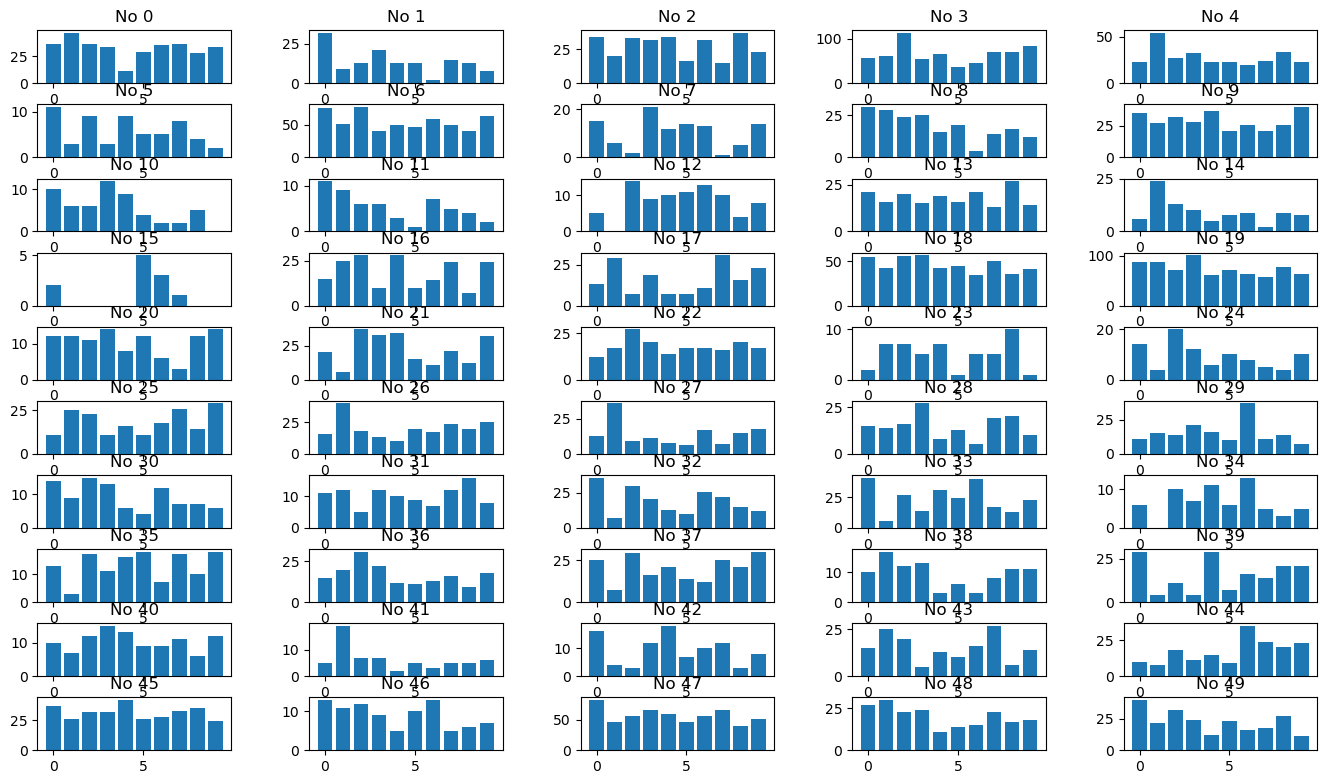

In [213]:
plt.figure(figsize=(16, 9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
cols = 5 if out_neurons >= 5 else out_neurons
rows = int((out_neurons / cols) + 1 if out_neurons % cols != 0 else out_neurons / cols)
for i in range(len(neuron_label_count)):
    ax = plt.subplot(rows, cols, i + 1, title=f"No {i}")
    plt.bar(neuron_label_count[i].keys(), neuron_label_count[i].values())


In [214]:
# associate each neuron with the label it spiked most for
# if the neuron never spiked pick a random label
from random import randrange

neuron_label = {neur: max(lab, key=lab.get) if any(lab.values()) else randrange(
    len(train_labels_u)) for neur, lab in neuron_label_count.items()}


In [215]:
# print labels associated to each neuron
print("Label associated to each neuron:")
print(neuron_label)


Label associated to each neuron:
{0: 1, 1: 0, 2: 8, 3: 2, 4: 1, 5: 0, 6: 2, 7: 3, 8: 0, 9: 9, 10: 3, 11: 0, 12: 2, 13: 8, 14: 1, 15: 5, 16: 2, 17: 7, 18: 3, 19: 3, 20: 3, 21: 2, 22: 2, 23: 8, 24: 2, 25: 9, 26: 1, 27: 1, 28: 3, 29: 6, 30: 2, 31: 8, 32: 0, 33: 0, 34: 6, 35: 5, 36: 2, 37: 9, 38: 1, 39: 0, 40: 3, 41: 1, 42: 4, 43: 7, 44: 6, 45: 4, 46: 0, 47: 0, 48: 1, 49: 0}


In [216]:
# group neurons into classes based on their label
label_class = {}
for neur, lab in neuron_label.items():
    label_class.setdefault(lab, list()).append(neur)


In [217]:
# print neurons associated to each label
print("Neuron set associated to each label:")
print(label_class)
recognized_labels = list(label_class.keys())
recognized_labels.sort()
print(
    f"Number of labels discovered: {len(label_class.keys())}, {recognized_labels}")


Neuron set associated to each label:
{1: [0, 4, 14, 26, 27, 38, 41, 48], 0: [1, 5, 8, 11, 32, 33, 39, 46, 47, 49], 8: [2, 13, 23, 31], 2: [3, 6, 12, 16, 21, 22, 24, 30, 36], 3: [7, 10, 18, 19, 20, 28, 40], 9: [9, 25, 37], 5: [15, 35], 7: [17, 43], 6: [29, 34, 44], 4: [42, 45]}
Number of labels discovered: 10, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [218]:
# switch to test set
inp.output = present_data_fn_from(reduced_test_images)
with model:
    test_weight_probe = nengo.Probe(conn, "weights", sample_every=sim_test_time)

with nengo_dl.Simulator(model, device="/cpu:0", progress_bar=False, unroll_simulation=10) as sim_test:
    for i in tqdm(range(nb_test_run)):
        sim_test.run(nb_sec_by_run, progress_bar=False)


100%|██████████| 7/7 [00:21<00:00,  3.05s/it]


<Figure size 640x480 with 0 Axes>

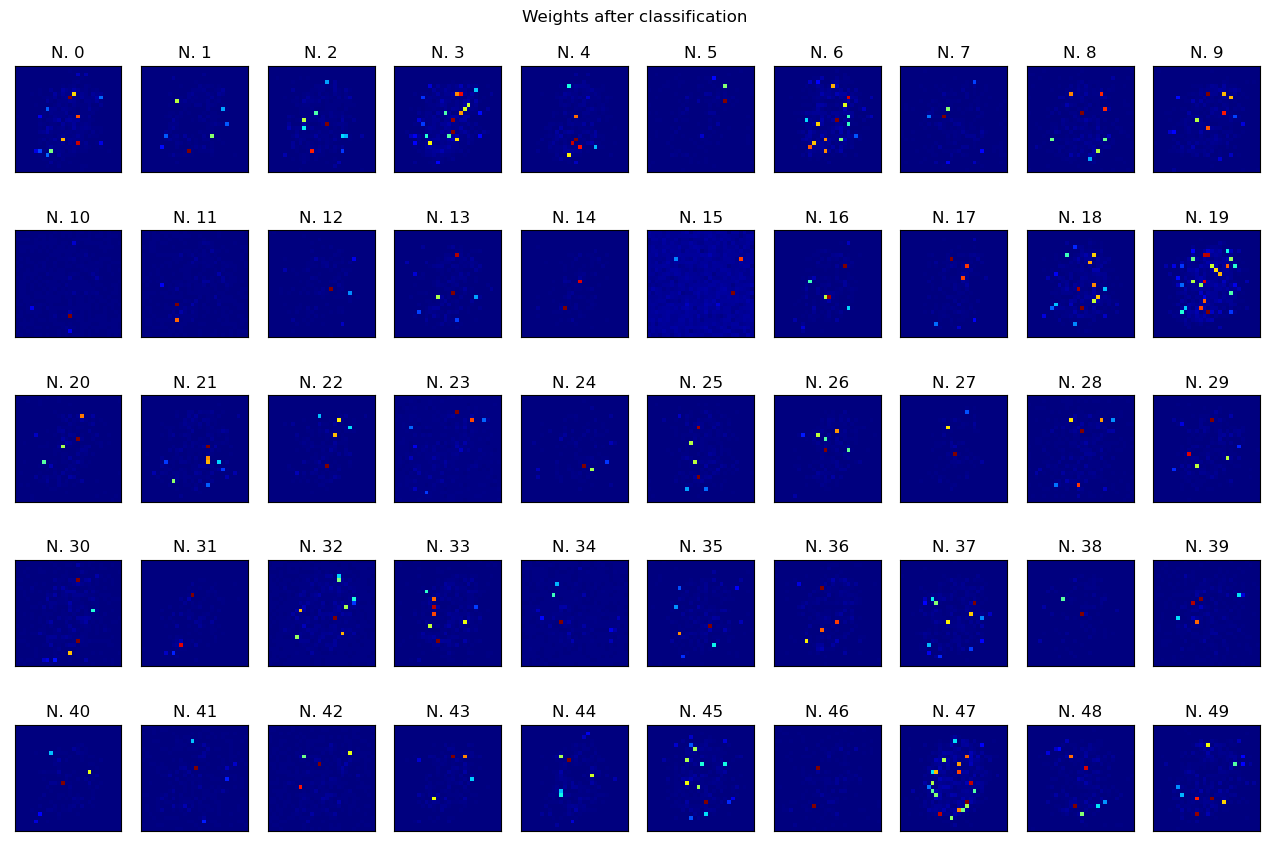

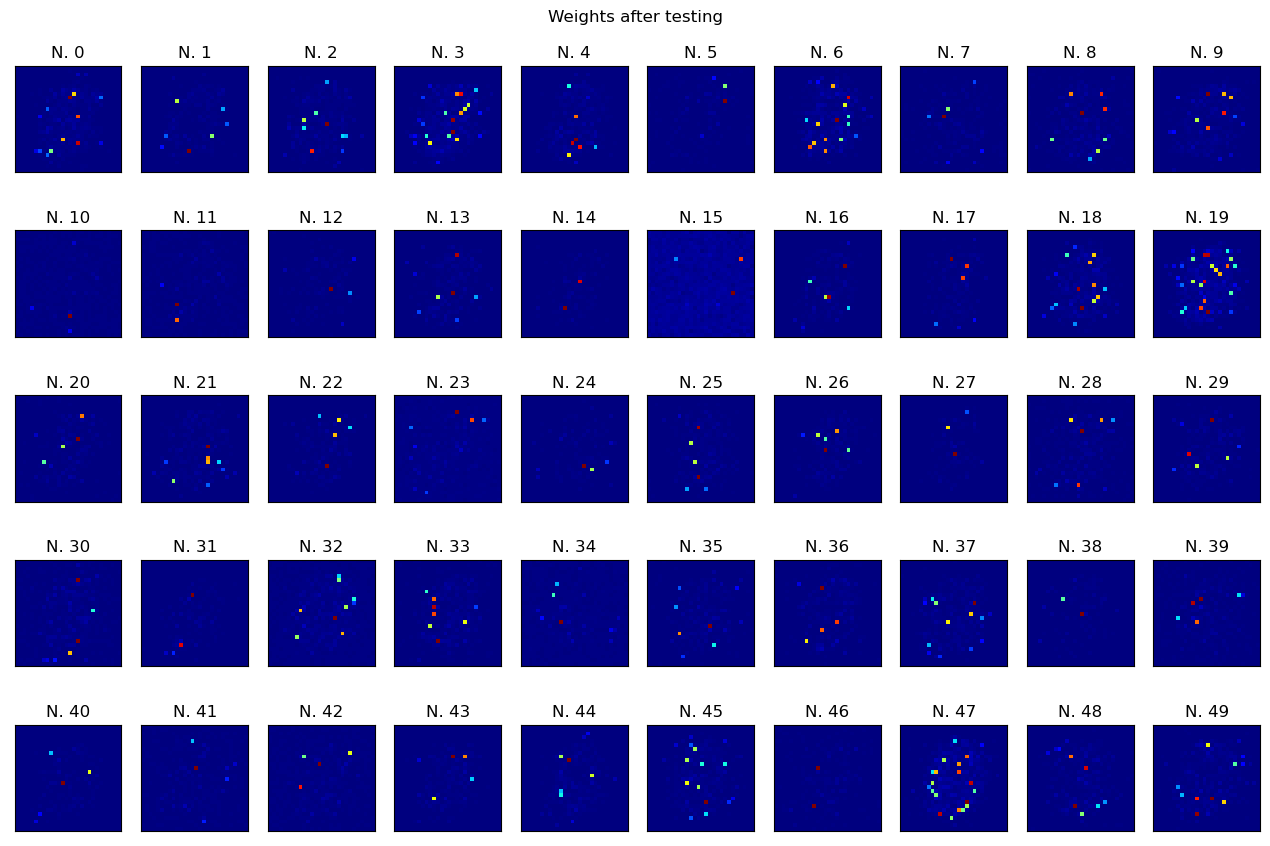

In [219]:
fig = heatmap(sim_class.data[weight_probe], t=-1,
              title="Weights after classification")
fig = heatmap(sim_test.data[test_weight_probe], t=-1,
              title="Weights after testing")

	Total: 3147
	Normalised standard dev.: 0.7959528024573274


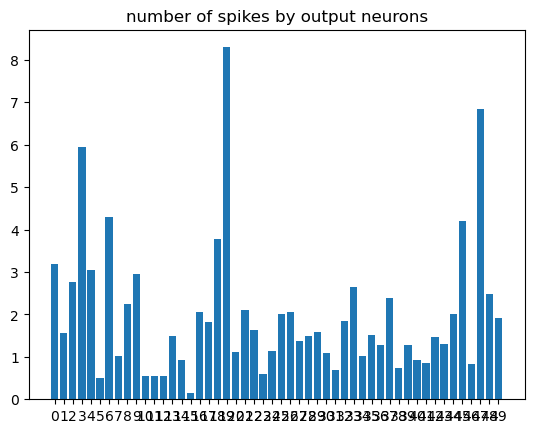

In [220]:
# print number of recorded spikes
num_spikes_test = np.sum(sim_test.data[post_probe] > 0, axis=0)

recorded_spikes_test = {str(i): x / np.sum(num_spikes_test) * 100
                   for i, x in enumerate(num_spikes_test)}
plt.bar(recorded_spikes_test.keys(), recorded_spikes_test.values())
plt.title("number of spikes by output neurons")
print("\tTotal:", np.sum(num_spikes_test))
print(
    f"\tNormalised standard dev.: {np.std( num_spikes_test ) / np.mean( num_spikes_test )}")


In [221]:

post_spikes_test = sim_test.data[post_probe].reshape(
    real_nb_test_img, -1, out_neurons)

# count neuron activations in response to each example
neuron_activations_test = np.count_nonzero(post_spikes_test, axis=1)

# use the neuron class with highest average activation as class prediction at each timestep
prediction = []
for t in range(real_nb_test_img):
    max_mean = 0
    max_lab = None
    for lab, neur in label_class.items():
        mean = np.mean(neuron_activations_test[t, neur])
        if mean > max_mean:
            max_mean = mean
            max_lab = lab
    if max_lab is None:
        max_lab = randrange(len(train_labels_u))
    prediction.append(max_lab)


recognized_labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


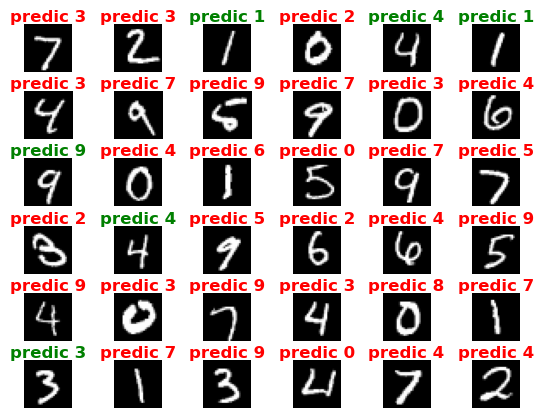

In [222]:
print("recognized_labels: ", recognized_labels)
plt.figure()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(36):
  plt.subplot(6, 6, i + 1)
  plt.imshow(test_images[i].reshape((28, 28)), cmap="gray")
  plt.axis("off")
  t = plt.title(f"predic {prediction[i]}", pad=0)
  t.set_color("red" if test_labels[i] != prediction[i] else "green")
  t.set_fontweight("bold" if test_labels[i] in recognized_labels else "light")


In [223]:
class_report = skm.classification_report(
    reduced_test_labels.ravel(), prediction, output_dict=True)


recognized_labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Classification results:
[0 1 2 3 4 5 6 7 8 9]
	Confusion matrix:



<AxesSubplot: >

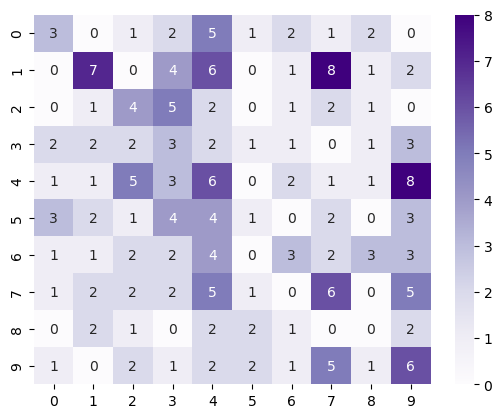

In [224]:
import seaborn as sn

print("recognized_labels: ", recognized_labels)

print("Classification results:")
print(test_labels_u)
print("\tConfusion matrix:\n")
sn.heatmap(skm.confusion_matrix(
    reduced_test_labels.ravel(), prediction, labels=test_labels_u), annot=True, cmap="Purples")


	Overall precision: 18.968904633378315 %
	Overall accuracy: 19.21182266009852 %


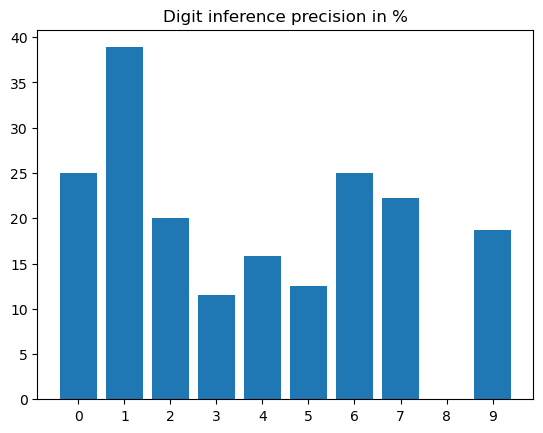

In [225]:
assert (isinstance(class_report, dict))

digit_inference_precision = {k: v["precision"] * 100 for k, v in class_report.items() if k.isdigit()}
plt.subplot()
plt.bar(digit_inference_precision.keys(), digit_inference_precision.values(), label="Precision")
plt.title("Digit inference precision in %")
print(
    f"\tOverall precision: {class_report[ 'macro avg' ][ 'precision' ] * 100} %")
print(f"\tOverall accuracy: {class_report[ 'accuracy' ] * 100} %")


In [226]:
# import os
# os.system("paplay /usr/share/sounds/freedesktop/stereo/complete.oga")


In the end, the results are not really satisfying.

Improvement track:
- Increase the number of output neurons to recognize more classes
- Try to add (a) convolution(s) to the network
- Try other/make learning rules
- Fiddle with the hyperparameters of the neuron types
- Improve the output decode  